In [1]:
from IPython.display import HTML
from IPython.display import Image

Magic the Gathering Card Recognition Project (Part 2): Now I Know My ABC's
=============================


<img src='ABCs.jpg' width="640" height="370" align="left">

**By: Pieter Leffers**,

*Starting Date: September 1, 2018*

*Completion Date: - -, 2018*

*Last Updated: Nov 28, 2018*

Part 2: Project Description
-----------------

For this second part of the project I will explore some of the data so far collected from Part 1 of the project in order to ascertain what materials are best for recognizing text within the borders and bounding boxes of the cards. Doing this step will establish how well text can be recognized on the cards to ascertain if I can use a text recognition model for identifying the cards or if I have to use a different strategy for identifying cards. The reasoning is clear I might as well as start with the easiest option first. If I can build or use an algorithm that can recognize and read the text then I am *at least* half-way with establishing the names of the cards. In order to run the text detection algorithm I  have several different sources of data to choose from thus far:

- Images gathered from the web
- Images captured from videos
- Computer generated 'scenes' created
- Videos themselves

Luckily for simplicity sake and demonstration purposes much of the text detection materials were already well designed by OpenCV but the usage is largely pulled from Adrian Rosebrock. https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

I will run text detection alorithms on each source of data and demonstrate how well each can be used for later in the project.


**Example: Image Gathered from the Web**

<img src="example1.jpg" width="360" height="370" align="left">

**Example: Image Captured from Video**

<img src="example2.png" width="360" height="370" align="left">

**Example: Computer generated scene**

<img src="example3.jpg" width="370" height="370" align="left">

**Example: Recorded Videos Themselves:**

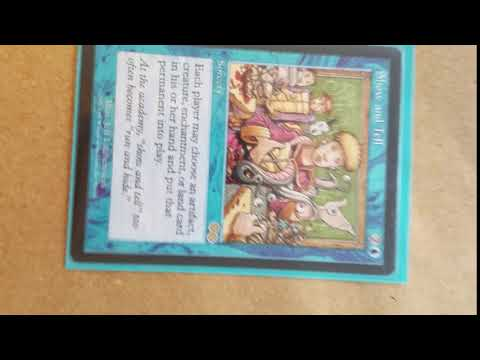

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("uHIOnX9ktjs")

_______________

**Challenges**
1. The materials have to represent text well and have to be easily visible
2. There can't be too much noise that would trick the detector into representing a false positive.
3. The video frames can be quite slow, it is probably best to write out the video than to play it and run text detection streaming.

Data Source(s):
-----------
- Previously gathered materials from Part 1: The Subgame

In [151]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

**Import packages**


In [24]:
import os
import cv2
import time
import pickle
import random
import imutils
import operator
import matplotlib
import pytesseract
import numpy as np
import imgaug as ia
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from pylab import rcParams
from imutils.video import FPS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
import matplotlib.patches as patches
from imutils.video import VideoStream
from pytesseract import image_to_osd, image_to_string

rcParams['figure.figsize'] = 7, 14 #set display size for matplotlib

ver=cv2.__version__
print('Matplotlib Version: {}'.format(matplotlib.__version__))
if float(ver[0])==3 and float(ver[-3:])<4.2:
    print('Please update OpenCV. This requires a minimum of OpenCV 3.4.2')
elif float(ver[0])>3:
    print('OpenCV Version:',cv2.__version__) 
else:
    print('OpenCV Version:',cv2.__version__)

Matplotlib Version: 2.2.2
OpenCV Version: 3.4.3


**Convenience Functions**

In [25]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    try:
        for polygon in polygons:
            # An polygon has either shape (n,2), 
            # either (n,1,2) if it is a cv2 contour (like convex hull).
            # In the latter case, reshape in (n,2)
            if len(polygon.shape)==3:
                polygon=polygon.reshape(-1,2)
            patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
            ax.add_patch(patch)
    except:
        print(img)

In [26]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return (boxes[pick].astype("int"),[pick])

In [27]:
def decode_predictions(scores, geometry, conf=0.5):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < conf:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [28]:
def ImgTextDetector(image,model,height=320,width=320,setConf=0.5):
    imgTextDict={}
    image = cv2.imread(image)
    orig = image.copy()
    (H, W) = image.shape[:2]
    print(('Image Height',H, 'Image Width',W))
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("loading EAST text detector...")
    net = cv2.dnn.readNet(ModelPath)
    
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("text detection took {:.6f} seconds".format(end - start))

    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < setConf:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
        
    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    boxes,pick = non_max_suppression(np.array(rects), probs=confidences)
    conf_loop=[]
    for p in pick[0]:
        conf_loop.append(confidences[p])
            
    box_loops=[]
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        interval=0
        # scale the bounding box coordinates based on the respective ratios
        box_loop_dict={}
        startX = int(startX * rW)
        box_loop_dict['startX']=startX
        startY = int(startY * rH)
        box_loop_dict['startY']=startY
        endX = int(endX * rW)
        box_loop_dict['endX']=endX
        endY = int(endY * rH)
        box_loop_dict['endY']=endY
        box_loop_dict['conf']=str(conf_loop[interval])
        box_loops.append(box_loop_dict)
        interval=+1
        
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2) 
 
    imgTextDict['boxes']=box_loops
    imgTextDict['image']=orig.tolist() 
    # show the output image
    return imgTextDict

In [29]:
def VidTextDetector(video,model,height=320,width=320,setConf=0.5):
    # import the necessary packages
    from imutils.video import VideoStream
    from imutils.video import FPS
    from imutils.object_detection import non_max_suppression
    import numpy as np
    import argparse
    import imutils
    import time
    import cv2

    def decode_predictions(scores, geometry,setConf=0.5):
        # grab the number of rows and columns from the scores volume, then
        # initialize our set of bounding box rectangles and corresponding
        # confidence scores
        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        # loop over the number of rows
        for y in range(0, numRows):
            # extract the scores (probabilities), followed by the
            # geometrical data used to derive potential bounding box
            # coordinates that surround text
            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            # loop over the number of columns
            for x in range(0, numCols):
                # if our score does not have sufficient probability,
                # ignore it
                if scoresData[x] < setConf:
                    continue

                # compute the offset factor as our resulting feature
                # maps will be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and
                # then compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height
                # of the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates
                # for the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                # add the bounding box coordinates and probability score
                # to our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

        # return a tuple of the bounding boxes and associated confidences
        return (rects, confidences)
    
     # initialize the original frame dimensions, new frame dimensions,
    # and ratio between the dimensions
    (W, H) = (None, None)
    (newW, newH) = (width, height)
    (rW, rH) = (None, None)

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("loading EAST text detector...")
    net = cv2.dnn.readNet(model)

    # if a video path was not supplied, grab the reference to the web cam
    if not video:
        print("starting video stream...")
        vs = VideoStream(src=0).start()
        time.sleep(1.0)

    # otherwise, grab a reference to the video file
    else:
        vs = cv2.VideoCapture(video)

    # start the FPS throughput estimator
    fps = FPS().start()

    # loop over frames from the video stream
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame = vs.read()
        frame = frame[1] if video else frame

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame, maintaining the aspect ratio
        frame = imutils.resize(frame, width=1000)
        orig = frame.copy()

        # if our frame dimensions are None, we still need to compute the
        # ratio of old frame dimensions to new frame dimensions
        if W is None or H is None:
            (H, W) = frame.shape[:2]
            rW = W / float(newW)
            rH = H / float(newH)

        # resize the frame, this time ignoring aspect ratio
        frame = cv2.resize(frame, (newW, newH))

        # construct a blob from the frame and then perform a forward pass
        # of the model to obtain the two output layer sets
        blob = cv2.dnn.blobFromImage(frame, 1.0, (newW, newH),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)

        # decode the predictions, then  apply non-maxima suppression to
        # suppress weak, overlapping bounding boxes
        (rects, confidences) = decode_predictions(scores, geometry)
        boxes = non_max_suppression(np.array(rects), probs=confidences)

        # loop over the bounding boxes
        for (startX, startY, endX, endY) in boxes:
            # scale the bounding box coordinates based on the respective
            # ratios
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            # draw the bounding box on the frame
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # update the FPS counter
        fps.update()

        # show the output frame
        cv2.imshow("Text Detection", orig)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

            # stop the timer and display FPS information
            fps.stop()
            print("elasped time: {:.2f}".format(fps.elapsed()))
            print("approx. FPS: {:.2f}".format(fps.fps()))
            vs.release()

    # close all windows
    cv2.destroyAllWindows()   
    return

In [30]:
def DetRecChar(image,model,conf=0.5,width=320,height=320,padding=0.0):
    imgTextDict={}
    # load the input image and grab the image dimensions
    image = cv2.imread(image)
    orig = image.copy()
    (origH, origW) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = origW / float(newW)
    rH = origH / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("loading EAST text detector...")
    net = cv2.dnn.readNet(model)

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # decode the predictions, then  apply non-maxima suppression to
    # suppress weak, overlapping bounding boxes
    (rects, confidences) = decode_predictions(scores, geometry)
    (boxes,pick) = non_max_suppression(np.array(rects), probs=confidences)

    # initialize the list of results
    results = []

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # in order to obtain a better OCR of the text we can potentially
        # apply a bit of padding surrounding the bounding box -- here we
        # are computing the deltas in both the x and y directions
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        # apply padding to each side of the bounding box, respectively
        startX = max(0, startX - dX)
        startY = max(0, startY - dY)
        endX = min(origW, endX + (dX * 2))
        endY = min(origH, endY + (dY * 2))

        # extract the actual padded ROI
        roi = orig[startY:endY, startX:endX]

        # in order to apply Tesseract v4 to OCR text we must supply
        # (1) a language, (2) an OEM flag of 4, indicating that the we
        # wish to use the LSTM neural net model for OCR, and finally
        # (3) an OEM value, in this case, 7 which implies that we are
        # treating the ROI as a single line of text
        config = ("-l eng --oem 1 --psm 7")
        text = pytesseract.image_to_string(roi, config=config)

        # add the bounding box coordinates and OCR'd text to the list
        # of results
        results.append(((startX, startY, endX, endY), text))

    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])

    # loop over the results
    box_loops=[]
    for ((startX, startY, endX, endY), text) in results:
        # display the text OCR'd by Tesseract
        #print("{}\n".format(text))

        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV, then draw the text and a bounding box surrounding
        # the text region of the input image
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        output = orig.copy()
        cv2.rectangle(output, (startX, startY), (endX, endY),
            (0, 0, 255), 2)
        cv2.putText(output, text, (startX, startY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
        box_loops.append(text)

        # show the output image
        plt.imshow(output)
        imgTextDict['text']=box_loops
        
    return imgTextDict

*Path to the Frozen EAST Detection Algorithm*

In [31]:
ModelPath='C:\\Users\\pmlef\\Desktop\\RML_work\\SageMaker\\TextDetector\\frozen_east_text_detection.pb'

Detecting text from internet gathered card
-------------------
In order to get this image I went on the gatherer (http://gatherer.wizards.com/Pages/Default.aspx) and downloaded an image of the card Brainstorm.

In [11]:
ImgPath=os.getcwd()+'\\data\\images\\Brainstorm\\Image.ashx_bs2.jpg'
ImgPath

'C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\images\\Brainstorm\\Image.ashx_bs2.jpg'

('Image Height', 310, 'Image Width', 223)
loading EAST text detector...
text detection took 0.887953 seconds


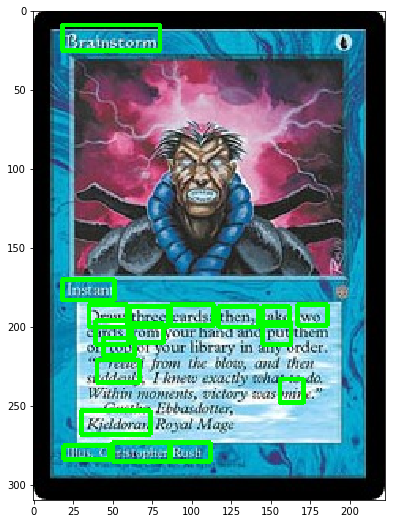

In [12]:
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.9)
img = np.array(Detections['image']).astype('uint8') #turn the image into 8-bit for proper displaying
display_img(img)

('Image Height', 311, 'Image Width', 223)
loading EAST text detector...
text detection took 0.875003 seconds


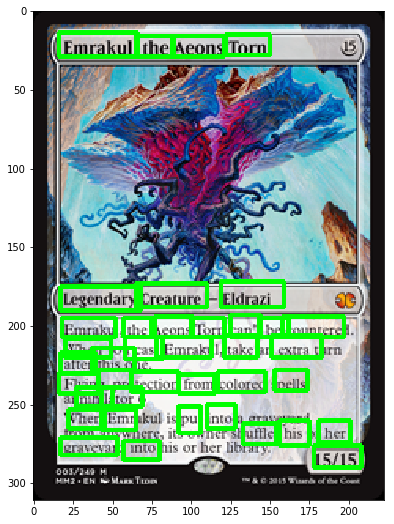

In [162]:
ImgPath=os.getcwd()+'\\data\\images\\Emrakul\\Image.ashxEtAT2.png'
Detections=ImgTextDetector(ImgPath,ModelPath)
img = np.array(Detections['image']).astype('uint8') #turn the image into 8-bit for proper displaying
display_img(img)

We can see that most of the text has been fairly accurately captured including the name; which is the most important feature. Even setting the confidence much greater than 70% we can see that the text is fairly well represented. I tried multiple cards and each of the internet gathered cards worked rather well, it is likely these will be an excellent source to build a simple working model from. However, the problem with these images is that these are certainly the BEST case scenerio and am unlikely to ever have video or images that are of this high of quality.

Detecting text from video captured image
-----------------

Next I want to see if any of the pictures I captured from video work with the text detection algorithm. These represent the second best quality. However, it is important to point out a lot of these images were captured under the best video conditions (as demonstrated by the example above).

('Image Height', 348, 'Image Width', 228)
loading EAST text detector...
text detection took 0.956533 seconds


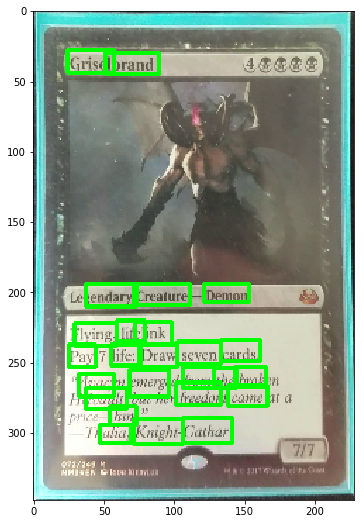

In [163]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Griselbrand\\678399589.png'
Detections=ImgTextDetector(ImgPath,ModelPath)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 348, 'Image Width', 228)
loading EAST text detector...
text detection took 0.839994 seconds


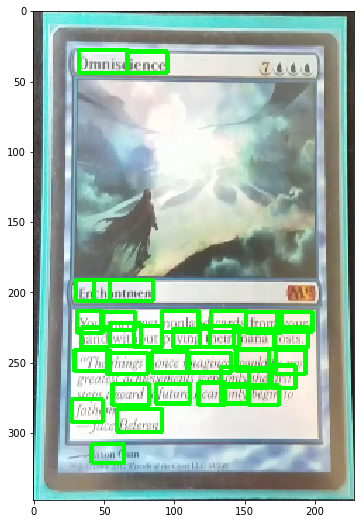

In [164]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Omniscience\\032231913.png'
Detections=ImgTextDetector(ImgPath,ModelPath)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 348, 'Image Width', 228)
loading EAST text detector...
text detection took 0.857504 seconds


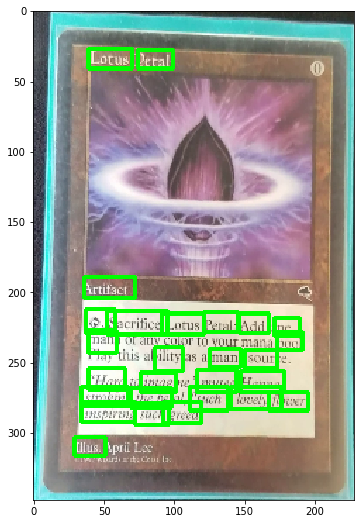

In [165]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Lotus_Petal\\231037880.png'
Detections=ImgTextDetector(ImgPath,ModelPath)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

We can see the images captured from the video are fairly well represented. Which is pretty great news because it is likely that we will be able to recognize text on videos and images from just an average cell-phone camera.

Text Detection from 'Scenes'
-------------

In the previous portion of the project I created a number of scenes from the snapshots shown above super-imposed on random backgrounds to be potentially used for training in the future.
It is nice having these images as they will likely be the best representation of what a captured image would be like while others are playing the game. How well is the text recognized in these images?

('Image Height', 720, 'Image Width', 720)
loading EAST text detector...
text detection took 0.848502 seconds


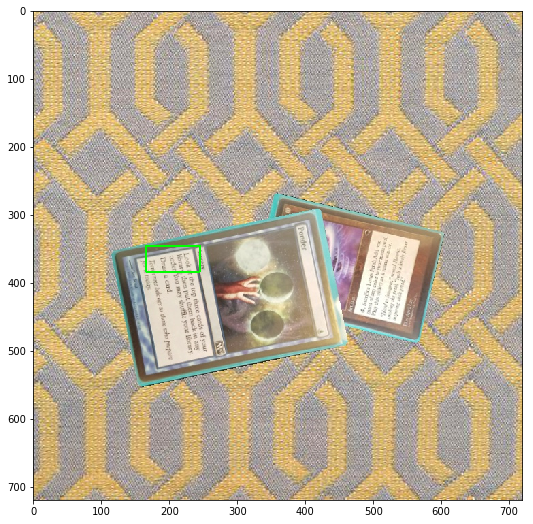

In [166]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\scenes\\val\\003506038.jpg'
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.2)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 720, 'Image Width', 720)
loading EAST text detector...
text detection took 0.877458 seconds


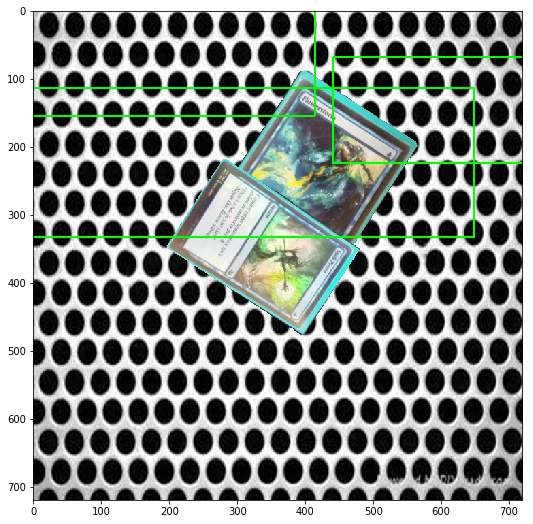

In [167]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\scenes\\val\\939890031.jpg'
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.4)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 720, 'Image Width', 720)
loading EAST text detector...
text detection took 0.871499 seconds


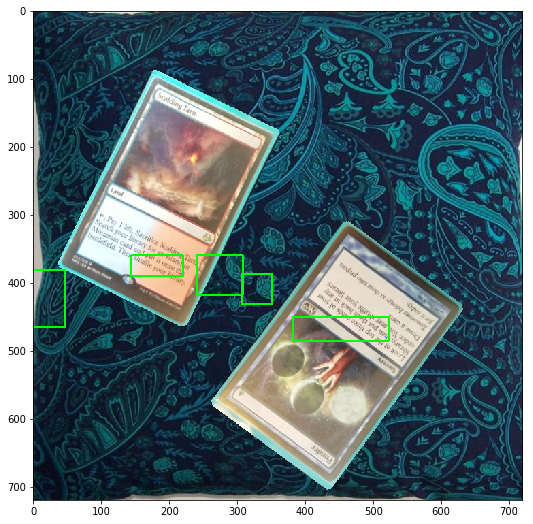

In [168]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\scenes\\val\\942961419.jpg'
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.4)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 720, 'Image Width', 720)
loading EAST text detector...
text detection took 0.867500 seconds


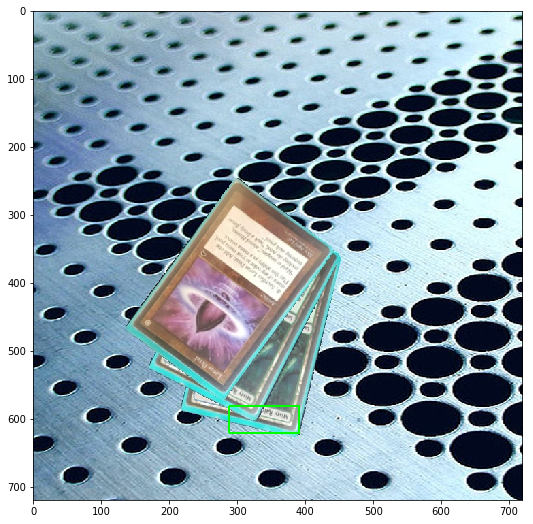

In [169]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\scenes\\val\\001775743.jpg'
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.4)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

('Image Height', 720, 'Image Width', 720)
loading EAST text detector...
text detection took 0.868449 seconds


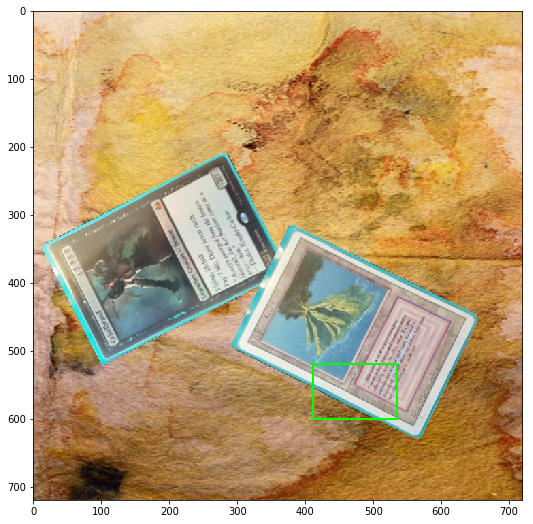

In [170]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\scenes\\val\\008740693.jpg'
Detections=ImgTextDetector(ImgPath,ModelPath,setConf=0.4)
img = np.array(Detections['image']).astype('uint8')
display_img(img)

The results are not good. In fact these are the best results of the bunch; many of the scene images failed to find text. This may be because the scenes aren't in focus enough or the text isn't large enough. I may have to deal with that later. But for now I have valuable information about the images for future reference.

Text Detection from Video
--------

Finally I'm going to run the text detection from a video recorded with the camera on my phone. 

In [171]:
VidPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\video\\Brainstorm.mp4'
VidTextDetector(VidPath,ModelPath,320,320,0.7)

loading EAST text detector...


<img src="screenshot.png" width="640" height="480" align="left">

In [172]:
VidPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\video\\Force_of_Will.mp4'
VidTextDetector(VidPath,ModelPath,320,320,0.7)

loading EAST text detector...


<img src="screenshot2.jpg" width="640" height="480" align="left">

For the recorded videos the results are merely *OK*. The model manages to identify text areas within the image but is having a hard time grabbing any specifics. Furthermore the video runs quite slow and the text detection algorithm is failing to pick up the crucial title of the card. Perhaps with a little modification I might be able to make the video work better, but for now I will use this as a last option until I can refine the system. For now I have a lot to consider with the videos.

Using Tesseract on Images
----------------

In [32]:
#from PIL import Image
#import pytesseract
#from pytesseract import image_to_osd, image_to_string

loading EAST text detector...


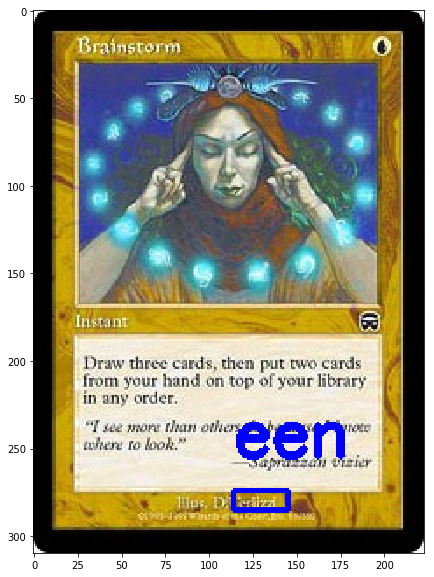

In [33]:
ImgPath=os.getcwd()+'\\data\\images\\Brainstorm\\Image.ashx_bs3.jpg'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [34]:
ImgtextDict

{'text': ['BTC T Ty So',
  'oll',
  'Instant',
  'put',
  'cards,',
  'Draw',
  'then',
  'three',
  'two',
  'cards',
  'your',
  'fon',
  'hand',
  'top:',
  'your',
  ') any',
  "' henoee",
  'because',
  'than',
  'T se',
  'more ,',
  'others',
  'there',
  'Saprassan',
  'pisker',
  'een']}

loading EAST text detector...


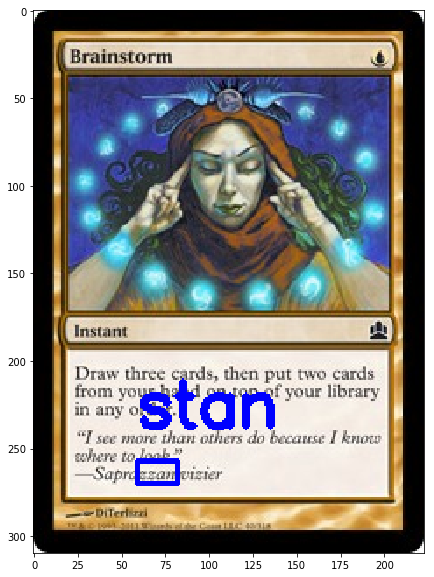

In [35]:
ImgPath=os.getcwd()+'\\data\\images\\Brainstorm\\Image.ashx_bs5.jpg'
ImgtextDict=DetRecChar(ImgPath,ModelPath,conf=0.2)

In [36]:
ImgtextDict

{'text': ['Brainstorm',
  're',
  'Instant',
  'Draw',
  'three',
  'cards',
  'two',
  'cards',
  'put |',
  'then',
  'oa',
  'Ra',
  'library',
  'any',
  '-orde',
  'in 3',
  'than',
  'know',
  'because',
  'others',
  'more:',
  'see',
  'look:',
  'co',
  'eee',
  'Sapre',
  'stan']}

loading EAST text detector...


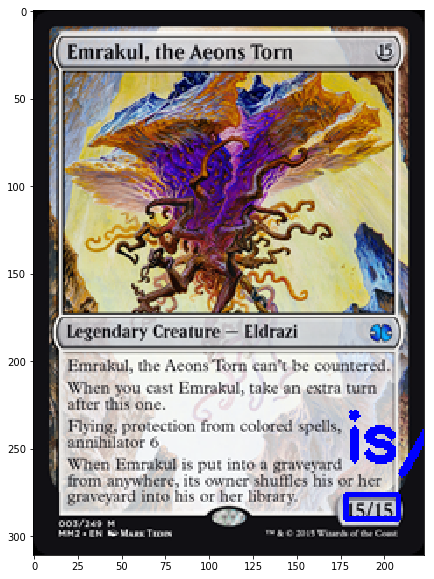

In [37]:
#ImgPath=os.getcwd()+'\\data\\images\\Emrakul\\Image.ashxEtAT2.png'
ImgPath=os.getcwd()+'\\data\\images\\Emrakul\\Image.ashxEtAT2.png'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [38]:
ImgtextDict

{'text': ['Emrakul.',
  'Torn',
  'Aeons',
  'the',
  'Eldrazi_',
  'Creature:',
  'Legendary',
  '=',
  'heons',
  'countera',
  'Emraku',
  '"Torn',
  'the',
  'be',
  'take',
  'etree',
  ': Emrain',
  '1 cast',
  'When 1',
  'alee',
  'after',
  'nels',
  'tection',
  'colored',
  'Flyin',
  'from',
  'nihil:',
  'lator',
  'into',
  'pul',
  'Emr',
  'When',
  'her',
  'his',
  'waffle:',
  'gravevar',
  '| into',
  'is/i5.']}

In [39]:
import difflib

words = ImgtextDict['text']
matches=difflib.get_close_matches('Emrurakul:', words)
print('Words matching first word in title Emrakul',matches[0])

Words matching first word in title Emrakul Emrakul.


loading EAST text detector...


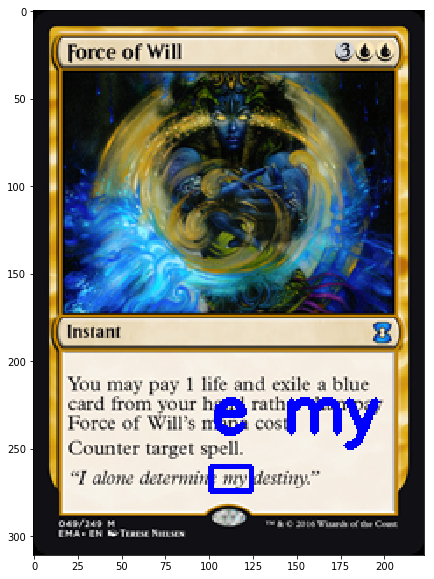

In [40]:
#ImgPath=os.getcwd()+'\\data\\images\\Emrakul\\Image.ashxEtAT2.png'
ImgPath=os.getcwd()+'\\data\\images\\Force of Will\\Image.ashxFoW3.png'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [41]:
ImgtextDict

{'text': ['Force o',
  'F Will',
  'Instant',
  'life',
  'blue',
  'and',
  'exile',
  'You',
  'may',
  'pay',
  'rathe',
  'from',
  'hand',
  'card',
  'pay',
  'your',
  'than',
  'Force',
  '',
  'cost.',
  'Counter',
  'enell.',
  'target',
  'determine',
  'alone',
  'destiny.',
  'e my']}

loading EAST text detector...


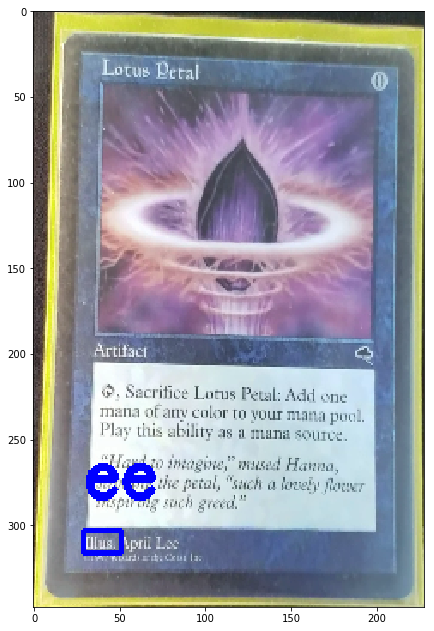

In [42]:
#ImgPath=os.getcwd()+'\\data\\images\\Emrakul\\Image.ashxEtAT2.png'
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Lotus_Petal\\231037880.png'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [43]:
ImgtextDict

{'text': ['Lotus',
  'Jetal',
  'roe',
  'os',
  'Sacrifice',
  'Peral-',
  'Lorms:',
  'Add',
  'ne',
  'man',
  'pod!',
  'ity',
  'mun:',
  'sun',
  'Hava',
  'animes',
  'Hanna,',
  'tmagi',
  'hosel i',
  'serowiny',
  '"seach',
  'te pei',
  'Rower',
  'snspareng',
  '| greed',
  'such',
  'ee']}

loading EAST text detector...


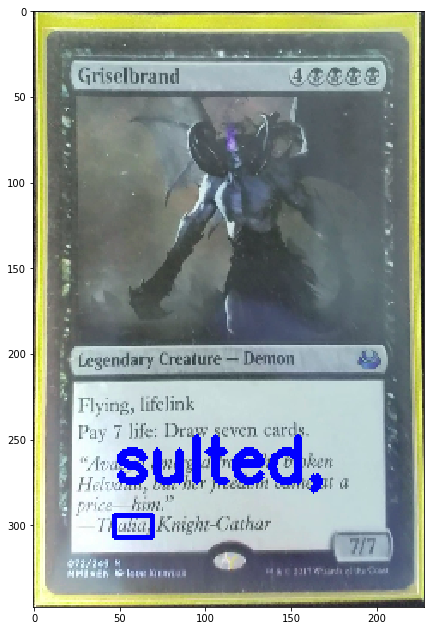

In [44]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Griselbrand\\678399589.png'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [45]:
ImgtextDict

{'text': ['Grisel',
  'Ibrand',
  'Demon',
  'Creature',
  'vendary',
  'lifel',
  'clink',
  '"lying,',
  'oat',
  'seven',
  'life:',
  'Draw',
  'Pay',
  'bk',
  'from',
  'the',
  'emeng',
  'Avae',
  '',
  'came',
  'Jnana,',
  'fein',
  'Cathar',
  'Knight-',
  'sulted,']}

loading EAST text detector...


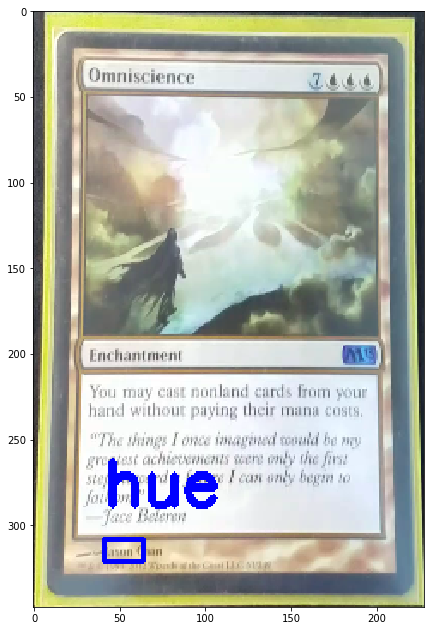

In [46]:
ImgPath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\data\\cards\\Omniscience\\032231913.png'
ImgtextDict=DetRecChar(ImgPath,ModelPath)

In [47]:
ImgtextDict

{'text': ['Omnisc',
  'ience',
  'Ench.',
  'chantmen',
  'You',
  'nonla',
  'cards',
  'from,',
  'your:',
  'may',
  'with',
  '1oUr',
  'their',
  's08t8,',
  'sand',
  '',
  'ving',
  'roould',
  '"The',
  'ey',
  'once i',
  'hangs:',
  'micagrineer',
  'first',
  'candy',
  'the',
  'can',
  'future',
  'ants',
  'noard',
  'bey',
  'fowl',
  'Beleren',
  'hue']}